# QDA + Pseudo Labeling + Gaussian Mixture = LB 0.975
The dataset for Kaggle competition "Instant Gratification" appears to be 512 datasets concatenated where each sub dataset is believed to be created by Sklearn's `make_classification`. EDA suggests the following parameters:
  
    X, y = make_classification(n_samples=1024, n_features=255, n_informative=33+x,
                n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=3,
                weights=None, flip_y=0.05, class_sep=1.0, hypercube=True, shift=0.0, 
                scale=1.0, shuffle=True, random_state=None) # where 0<=x<=14
                
The important parameters to note are `n_clusters_per_class=3` and `n_informative=33+x`. This means that the data resides in `33+x` dimensional space within 6 hyper-ellipsoids. Each hyper-ellipsoid is a multivariate Gaussian distribution therefore the best classifiers to use are QDA, Pseudo Labeling, and Gaussian Mixture. (See appendix for EDA showing 3 clusters per class).

![image](http://playagricola.com/Kaggle/six62019.jpg)


# Load Libraries and Data

In [1]:
# IMPORT LIBRARIES
import numpy as np, pandas as pd, os
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [2]:
# LOAD TRAIN AND TEST
df_train = pd.read_csv('../input/instant-gratification/train.csv')
df_test = pd.read_csv('../input/instant-gratification/test.csv')
sample = pd.read_csv('../input/instant-gratification/sample_submission.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Columns: 258 entries, id to target
dtypes: float64(255), int64(2), object(1)
memory usage: 516.0+ MB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Columns: 257 entries, id to gamy-white-monster-expert
dtypes: float64(255), int64(1), object(1)
memory usage: 257.0+ MB


In [5]:
df_train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [6]:
df_test.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
0,ba88c155ba898fc8b5099893036ef205,-0.155789,0.761549,1.156785,-0.272358,-1.302155,1.560988,-1.815729,-0.702968,0.435537,1.283895,-0.343518,-1.838579,-0.042550,-0.445104,-1.095100,0.705350,-0.380414,-0.795682,-0.758300,-0.414352,-0.777386,-1.161663,0.066044,-1.344336,1.093101,0.050480,-0.237973,-1.909876,2.958334,0.500903,-0.279001,-0.119306,1.211495,-0.755415,0.033202,-1.496447,1.361191,0.934949,1.664903,...,1.105099,-1.039678,-0.020976,-2.549582,-0.042384,-0.080888,-1.337010,-0.454110,0.147896,1.429689,1.568941,-0.708524,-1.353830,-1.022430,0.223778,0.584740,-1.115830,1.620426,-0.806678,0.649135,-0.052494,-0.947633,2.981762,-2.321268,0.106400,-0.350618,-0.121869,-0.898826,-0.751598,-0.732516,-4.207352,0.404394,0.695667,0.515584,1.339533,2.005131,-1.832629,-0.454067,-0.204909,-0.314752
1,7cbab5cea99169139e7e6d8ff74ebb77,-4.528525,-0.158527,0.616473,-0.172137,1.255351,0.064565,-1.124906,-1.826855,-1.429915,-0.777585,-0.250756,-0.416648,-0.142929,-0.977553,1.384768,2.393905,-1.913877,1.145628,-1.145112,-0.502978,1.200528,-6.464249,-0.427974,0.656148,-1.808154,-1.039081,-0.604521,2.109838,5.174223,-0.352850,7.710951,0.442175,-0.752437,-0.757275,0.535649,3.085409,1.297368,-2.859359,-1.626998,...,0.041613,-6.718112,-0.562997,0.224132,-0.896035,0.275753,-0.932541,0.279365,-0.491741,0.451097,-0.269904,-0.825188,-0.505424,-0.955194,-0.394282,0.853037,0.521197,2.146393,-0.520788,-1.047142,-2.104112,-0.647331,3.002434,0.249064,0.923207,1.169519,-0.914550,-0.152553,1.291979,0.344865,-0.219057,-1.473936,-1.230680,2.064435,-0.297421,-0.499721,0.138128,-1.674848,-2.368582,0.185971
2,7baaf361537fbd8a1aaa2c97a6d4ccc7,1.807488,-0.

In [7]:
print("Train shape: {}, Test shape: {}".format(df_train.shape, df_test.shape))

Train shape: (262144, 258), Test shape: (131072, 257)


Interactions

Below shows the interactions between wheezy-copper-turtle-magic and the other variables. Each variable by itself cannot predict target well, but when wheezy-copper-turtle-magic equals a specific value then other variables can predict target well. For example, when wheezy-copper-turtle-magic = 0 then zippy-harlequin-otter-grandmaster is positively correlated with target. And when wheezy-copper-turtle-magic = 0 then hasty-puce-fowl-fepid is negatively correlated with target.

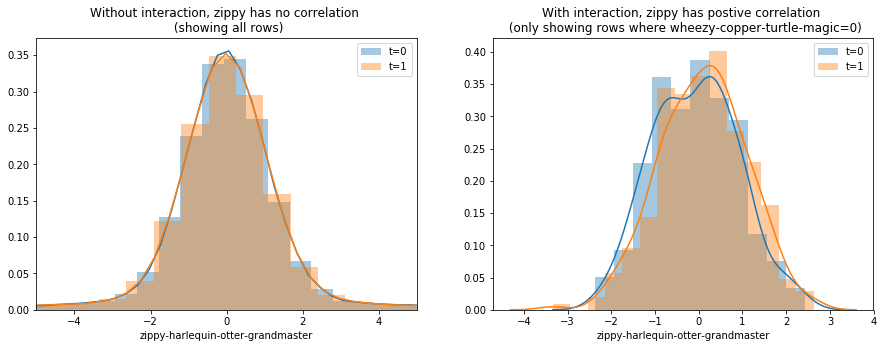

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(15,5))

# PLOT ALL ZIPPY
plt.subplot(1,2,1)
sns.distplot(df_train[ (df_train['target']==0) ]['zippy-harlequin-otter-grandmaster'], label = 't=0')
sns.distplot(df_train[ (df_train['target']==1) ]['zippy-harlequin-otter-grandmaster'], label = 't=1')
plt.title("Without interaction, zippy has no correlation \n (showing all rows)")
plt.xlim((-5,5))
plt.legend()

# PLOT ZIPPY WHERE WHEEZY-MAGIC=0
plt.subplot(1,2,2)
sns.distplot(df_train[ (df_train['wheezy-copper-turtle-magic']==0) & (df_train['target']==0) ]
             ['zippy-harlequin-otter-grandmaster'], label = 't=0')
sns.distplot(df_train[ (df_train['wheezy-copper-turtle-magic']==0) & (df_train['target']==1) ]
             ['zippy-harlequin-otter-grandmaster'], label = 't=1')
plt.title("With interaction, zippy has postive correlation \n (only showing rows where wheezy-copper-turtle-magic=0)")
plt.legend()

plt.show()

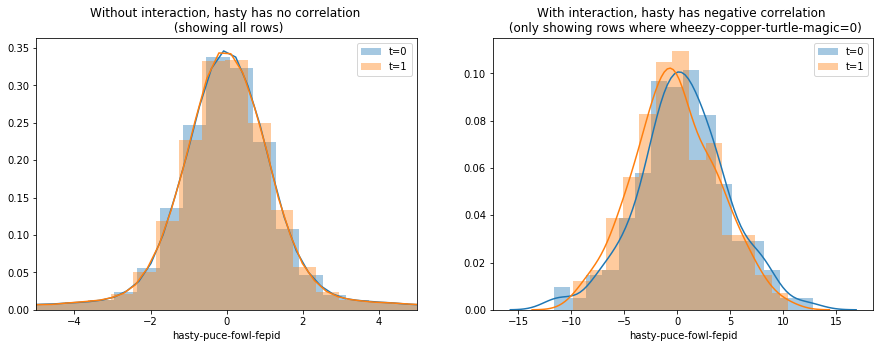

In [9]:
plt.figure(figsize=(15,5))

# PLOT ALL HASTY
plt.subplot(1,2,1)
sns.distplot(df_train[ (df_train['target']==0) ]['hasty-puce-fowl-fepid'], label = 't=0')
sns.distplot(df_train[ (df_train['target']==1) ]['hasty-puce-fowl-fepid'], label = 't=1')
plt.title("Without interaction, hasty has no correlation \n (showing all rows)")
plt.xlim((-5,5))
plt.legend()

# PLOT HASTY WHERE WHEEZY-MAGIC=0
plt.subplot(1,2,2)
sns.distplot(df_train[ (df_train['wheezy-copper-turtle-magic']==0) & (df_train['target']==0) ]
             ['hasty-puce-fowl-fepid'], label = 't=0')
sns.distplot(df_train[ (df_train['wheezy-copper-turtle-magic']==0) & (df_train['target']==1) ]
             ['hasty-puce-fowl-fepid'], label = 't=1')
plt.title("With interaction, hasty has negative correlation \n (only showing rows where wheezy-copper-turtle-magic=0)")
plt.legend()

plt.show()

In [14]:
df_train = pd.read_csv('../input/instant-gratification/train.csv')
df_test = pd.read_csv('../input/instant-gratification/test.csv')

Structure of Entire Dataset

The dataset for Kaggle's "Instant Gratification" competition appears to be 512 partial datasets combined as confirmed by experiments and EDA. Consequently each variable (column) appears to be the sum of 512 Gaussians. Below is a sketch of the dataset sorted by the column wheezy-copper-turtle-magic (using 1-based indexing).

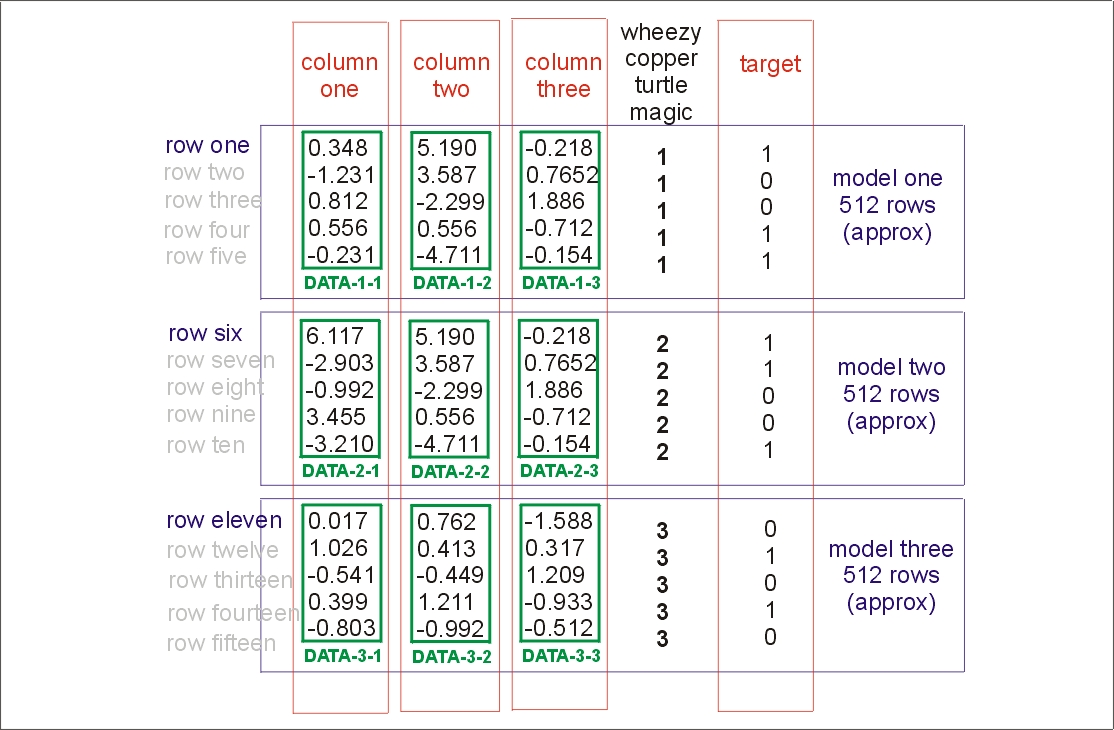


In the dataset drawing above, column one is the summation of Gaussians DATA-1-1, DATA-2-1, and DATA-3-1. If you plot these histograms separately, you see that they are Gaussians.

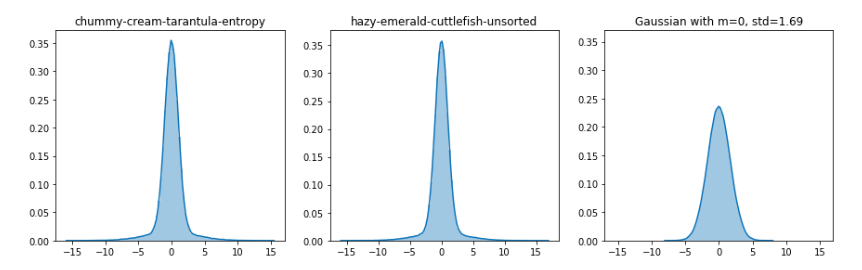

**Structure of Partial Datasets**

**There are 512 unique values of wheezy-copper-turtle-magic and there are 262144 rows of data. For each value of magic there are approximately 512 = 262144/512 associated rows that form a partial dataset.**


**These partial datasets each have (approx) 512 rows and 255 features. We can model each partial dataset individually** and this can achieve high overall accuracy of at least LB 0.928 as shown here. (Predictions on test.csv are made using the appropriate model). The features for model one are DATA-1-1, DATA-1-2, DATA-1-3, etc. Each feature has a Gaussian distribution. When building a model with only 512 observations and 255 features, it is important to reduce the number of features to prevent overfitting.

Determine structure of private dataset

As described here, **both the train and public test dataset appear to be 512 datasets combined. Each partial dataset has 256 variables. Therefore there are 131072 = 512 * 216 blocks of data. Each block of data has either standard deviation approx 1.0 or approx 3.75. The blocks with standard deviation 1.0 seem to be useless while the blocks with standard deviation 3.75 seem to be useful.** Does the private test dataset have this same structure?

(There are 512 partial datasets within the full dataset. **And each partial dataset has a different set of approximately 40 important features as identified by different standard deviations.**) We have observed that both the training dataset and public test dataset have this structure. Does the private dataset also have this structure? In this kernel, we probe the private dataset and confirm that it has the same structure.

In [15]:
print("Train shape: {}, Test shape: {}".format(df_train.shape, df_test.shape))

Train shape: (262144, 258), Test shape: (131072, 257)


In [16]:
df_train.describe()

,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,flaky-goldenrod-bat-noise,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
count,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,...,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000
mean,0.005924,0.000936,-0.012530,-0.005688,0.001607,0.007878,-0.003500,-0.005927,0.002664,0.020485,-0.001629,0.008115,-0.001445,0.006434,0.013150,-0.016462,0.014498,0.000990,-0.004702,-0.010490,0.006592,-0.007705,0.010857,-0.011858,-0.005172,-0.012855,-0.003606,0.001209,0.007980,-0.005911,-0.000397,-0.000490,-0.013010,-0.000040,0.003882,-0.008507,-0.009352,0.007037,0.004091,-0.011576,...,-0.002381,-0.010963,0.005069,0.001779,0.011217,-0.000718,-0.008141,0.003521,0.011593,-0.011187,0.001626,0.000656,0

In [17]:
df_test.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
0,ba88c155ba898fc8b5099893036ef205,-0.155789,0.761549,1.156785,-0.272358,-1.302155,1.560988,-1.815729,-0.702968,0.435537,1.283895,-0.343518,-1.838579,-0.042550,-0.445104,-1.095100,0.705350,-0.380414,-0.795682,-0.758300,-0.414352,-0.777386,-1.161663,0.066044,-1.344336,1.093101,0.050480,-0.237973,-1.909876,2.958334,0.500903,-0.279001,-0.119306,1.211495,-0.755415,0.033202,-1.496447,1.361191,0.934949,1.664903,...,1.105099,-1.039678,-0.020976,-2.549582,-0.042384,-0.080888,-1.337010,-0.454110,0.147896,1.429689,1.568941,-0.708524,-1.353830,-1.022430,0.223778,0.584740,-1.115830,1.620426,-0.806678,0.649135,-0.052494,-0.947633,2.981762,-2.321268,0.106400,-0.350618,-0.121869,-0.898826,-0.751598,-0.732516,-4.207352,0.404394,0.695667,0.515584,1.339533,2.005131,-1.832629,-0.454067,-0.204909,-0.314752
1,7cbab5cea99169139e7e6d8ff74ebb77,-4.528525,-0.158527,0.616473,-0.172137,1.255351,0.064565,-1.124906,-1.826855,-1.429915,-0.777585,-0.250756,-0.416648,-0.142929,-0.977553,1.384768,2.393905,-1.913877,1.145628,-1.145112,-0.502978,1.200528,-6.464249,-0.427974,0.656148,-1.808154,-1.039081,-0.604521,2.109838,5.174223,-0.352850,7.710951,0.442175,-0.752437,-0.757275,0.535649,3.085409,1.297368,-2.859359,-1.626998,...,0.041613,-6.718112,-0.562997,0.224132,-0.896035,0.275753,-0.932541,0.279365,-0.491741,0.451097,-0.269904,-0.825188,-0.505424,-0.955194,-0.394282,0.853037,0.521197,2.146393,-0.520788,-1.047142,-2.104112,-0.647331,3.002434,0.249064,0.923207,1.169519,-0.914550,-0.152553,1.291979,0.344865,-0.219057,-1.473936,-1.230680,2.064435,-0.297421,-0.499721,0.138128,-1.674848,-2.368582,0.185971
2,7baaf361537fbd8a1aaa2c97a6d4ccc7,1.807488,-0.

In [18]:
sample.head()

,id,target
0,ba88c155ba898fc8b5099893036ef205,0.5
1,7cbab5cea99169139e7e6d8ff74ebb77,0.5
2,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.5
3,2e1350fe94ec9f2220bec5245e5e9265,0.5
4,626ce222351b68b259f73de172f11249,0.5


# Identify Useful Features
the data appears to be 131072 = 512 * 256 blocks of data where some are useful and some are useless.

In [19]:
# IDENTIFY USEFUL FEATURES PER MAGIC SUB-DATASET
useful = np.zeros((256,512))
for i in range(512):
    partial = df_train[ df_train['wheezy-copper-turtle-magic']==i ]
    useful[:,i] = np.std(partial.iloc[:,1:-1], axis=0)
useful = useful > 1.5

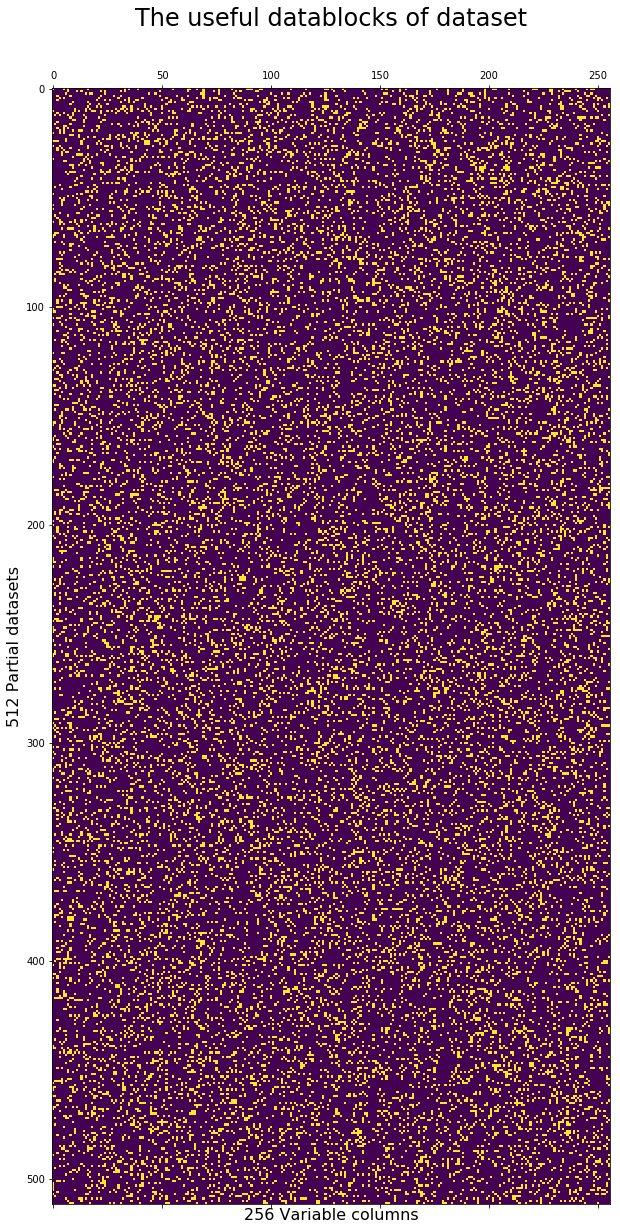

In [20]:
import matplotlib.pyplot as plt

# PLOT BOOLEANS OF USEFUL BLOCKS
plt.figure(figsize=(10,20))
plt.matshow(useful.transpose(),fignum=1)
plt.title('The useful datablocks of dataset', fontsize=24)
plt.xlabel('256 Variable columns', fontsize=16)
plt.ylabel('512 Partial datasets', fontsize=16)
plt.show()

In [21]:
useful = np.sum( useful, axis=0 )

What is Pseudo Labeling?

Pseudo labeling is the process of adding confident predicted test data to your training data. Pseudo labeling is a 5 step process. (1) Build a model using training data. (2) Predict labels for an unseen test dataset. (3) Add confident predicted test observations to our training data (4) Build a new model using combined data. And (5) use your new model to predict the test data and submit to Kaggle. Here is a pictorial explanation using sythetic 2D data.

Why does Pseudo Labeling work?

Pseudo labeling helps all types of models because all models can be visualized as finding shapes of target=1 and target=0 in p-dimensional space. See here for examples. More points allow for better estimation of shapes.

# Model and Predict
1. First we use QDA plus Pseudo Labeling 
2. Next we will use these predictions (pseudo labels) to find the 6 ellipses. We separately find the 3 ellipses of the target=1 data and 3 ellipses of the target=0 data using Sklearn GaussianMixture. 
3. Then we label each point with 0, 1, 2, 3, 4, 5 representing which ellipse it belongs to. 
4. Finally we train QDA on these 6 ellipses and use QDA to make our final predictions with `Pr(target=1) = Pr(in ellipse 3) + Pr(in ellipse 4) + Pr(in ellipse 5)`. (See appendix 2 for advanced techniques).

For validation, we didn't use typical k-folds CV. Instead we created synthetic data and optimized our technique on synthetic data. This has proven to be more reliable than CV. Also it allows our model to use all 1024 rows of sub datasets when building models. Our model has demonstrated that on average it can perfectly classify Sklearn's `make_classification` data. However many other participants can too. So randomness is added which allows us to do better than perfect sometimes. Then two random versions' output were submitted to Kaggle and hopefully those are the high scoring ones! :P

When the code below is run locally, it generates synthetic data and calculates validation AUC. When the code is submitted to Kaggle, it uses real data and predicts `test.csv`.

[1]: https://www.kaggle.com/cdeotte/pseudo-labeling-qda-0-969

In [22]:
# RUN LOCALLY AND VALIDATE
models = 512
RunLocally = True

# RUN SUBMITTED TO KAGGLE
if len(df_test)>512*300: 
    repeat = 1
    models = 512 * repeat
    RunLocally = False
    
# INITIALIZE
all_preds = np.zeros(len(df_test))
all_y_pu = np.array([])
all_y_pr = np.array([])
all_preds_pu = np.array([])
all_preds_pr = np.array([])

# MODEL AND PREDICT
for k in range(models):
    
    # IF RUN LOCALLY AND VALIDATE
    # THEN USE SYNTHETIC DATA
    if RunLocally:
        obs = 512
        X, y = make_classification(n_samples=1024, n_features=useful[k%512], 
                    n_informative=useful[k%512], n_redundant=0, n_repeated=0,
                    n_classes=2, n_clusters_per_class=3, weights=None, flip_y=0.05,
                    class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True,
                    random_state=None)
        
    # IF RUN SUBMITTED TO KAGGLE
    # THEN USE REAL DATA
    else:
        df_train2 = df_train[df_train['wheezy-copper-turtle-magic']==k%512]
        df_test2 = df_test[df_test['wheezy-copper-turtle-magic']==k%512]
        sel = VarianceThreshold(1.5).fit(df_train2.iloc[:,1:-1])
        df_train3 = sel.transform(df_train2.iloc[:,1:-1])
        df_test3 = sel.transform(df_test2.iloc[:,1:])
        obs = df_train3.shape[0]
        X = np.concatenate((df_train3,df_test3),axis=0)
        y = np.concatenate((df_train2['target'].values,np.zeros(len(df_test2))))
    
    # TRAIN AND TEST DATA
    train = X[:obs,:]
    train_y = y[:obs]
    test = X[obs:,:]
    test_y = y[obs:]
    comb = X
                
    # FIRST MODEL : QDA
    clf = QuadraticDiscriminantAnalysis(priors = [0.5,0.5])
    clf.fit(train,train_y)
    test_pred = clf.predict_proba(test)[:,1]
    
    # SECOND MODEL : PSEUDO LABEL + QDA
    test_pred = test_pred > np.random.uniform(0,1,len(test_pred)) #randomness
    clf = QuadraticDiscriminantAnalysis(priors = [0.5, 0.5])
    clf.fit(comb, np.concatenate((train_y,test_pred)) )
    test_pred = clf.predict_proba(test)[:,1]
   
    # THIRD MODEL : PSEUDO LABEL + GAUSSIAN MIXTURE
    test_pred = test_pred > np.random.uniform(0,1,len(test_pred)) #randomness
    all_y = np.concatenate((train_y,test_pred))
    least = 0; ct = 1; thx=150
    while least<thx:
        # STOPPING CRITERIA
        if ct>=10: thx -= 10
        else: thx = 150
        # FIND CLUSTERS 
        clusters = np.zeros((len(comb),6))
        # FIND THREE TARGET=1 CLUSTERS
        train4 = comb[ all_y==1, :]
        clf = GaussianMixture(n_components=3).fit(train4) #randomness
        clusters[ all_y==1, 3:] = clf.predict_proba(train4)
        # FIND THREE TARGET=0 CLUSTERS
        train4 = comb[ all_y==0, :]
        clf = GaussianMixture(n_components=3).fit(train4) #randomness
        clusters[ all_y==0, :3] = clf.predict_proba(train4)
        # ADJUST CLUSTERS (EXPLAINED IN KERNEL COMMENTS)
        for j in range(5): clusters[:,j+1] += clusters[:,j]
        rand = np.random.uniform(0,1,clusters.shape[0])
        for j in range(6): clusters[:,j] = clusters[:,j]>rand #randomness
        clusters2 = 6 - np.sum(clusters,axis=1)
        # IF IMBALANCED TRY AGAIN 
        least = pd.Series(clusters2).value_counts().min(); ct += 1

    # FOURTH MODEL : GAUSSIAN MIXTURE + QDA
    clf = QuadraticDiscriminantAnalysis(priors = [0.167, 0.167, 0.167, 0.167, 0.167, 0.167])
    clf.fit(comb,clusters2)
    pds = clf.predict_proba(test)
    test_pred = pds[:,3]+pds[:,4]+pds[:,5]
        
    # IF RUN LOCALLY, STORE TARGETS AND PREDS
    if RunLocally:
        all_y_pu = np.append(all_y_pu, test_y[:256])
        all_y_pr = np.append(all_y_pr, test_y[256:])
        all_preds_pu = np.append(all_preds_pu, test_pred[:256])
        all_preds_pr = np.append(all_preds_pr, test_pred[256:])
    # IF RUN SUBMIT TO KAGGLE, PREDICT TEST.CSV
    else:
        all_preds[df_test2.index] += test_pred / repeat
        
    # PRINT PROGRESS
    if ((k+1)%64==0)|(k==0): print('modeled and predicted',k+1,'magic sub datasets')

# IF RUN LOCALLY, COMPUTE AND PRINT VALIDATION AUCS
if RunLocally: 
    all_y_pu_pr = np.concatenate((all_y_pu,all_y_pr))
    all_preds_pu_pr = np.concatenate((all_preds_pu,all_preds_pr))
    auc1 = roc_auc_score(all_y_pu_pr, all_preds_pu_pr)
    auc2 = roc_auc_score(all_y_pu, all_preds_pu)
    auc3 = roc_auc_score(all_y_pr, all_preds_pr)
    print()
    print('Validation AUC =',np.round(auc1,5))
    print('Approx Public LB =',np.round(auc2,5))
    print('Approx Private LB =',np.round(auc3,5))

modeled and predicted 1 magic sub datasets
modeled and predicted 64 magic sub datasets
modeled and predicted 128 magic sub datasets
modeled and predicted 192 magic sub datasets
modeled and predicted 256 magic sub datasets
modeled and predicted 320 magic sub datasets
modeled and predicted 384 magic sub datasets
modeled and predicted 448 magic sub datasets
modeled and predicted 512 magic sub datasets

Validation AUC = 0.97479
Approx Public LB = 0.97401
Approx Private LB = 0.97556


# Submit to Kaggle
Alright, let's cross our fingers and hope that our submission has a high private LB !!

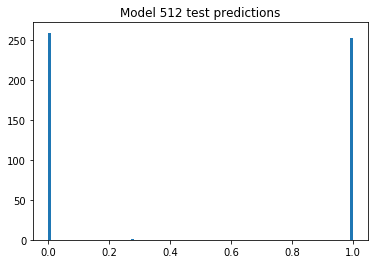

In [23]:
sub = pd.read_csv('../input/instant-gratification/sample_submission.csv')
sub['target'] = all_preds
sub.to_csv('submission.csv',index=False)

plt.hist( test_pred ,bins=100)
plt.title('Model 512 test predictions')
plt.show()

# Appendix 1 - EDA revealing n_clusters_per_class = 3
We believe the data was made from Sklearn's `make_classification`. An important question is what parameter for `n_clusters_per_class` did Kaggle use? 

According to Sklearn's documentation [here][1]:

> This initially creates clusters of points normally distributed (std=1) about vertices of an n-informative-dimensional hypercube with sides of length 2 * class_sep and assigns an equal number of clusters to each class.

In three dimensions that means, that the clusters will be centered at one of these 8 locations: (-1, -1, -1), (-1, -1, 1), (-1, 1, -1), (-1, 1, 1), (1, -1, -1), (1, -1, 1), (1, 1, -1), (1, 1, 1) where you replace all 1's by `class_sep`. If you create 1024 rows of data and have 2 clusters per class, then for `target=1`, you may have 256 points centered at (-1, 1, -1) and 256 points centered at (1, 1, -1). Then for `target=0`, you may have 256 points centered at (1, 1, 1) and 256 points centered at (-1, -1, 1).

Using EDA, we can determine the number of clusters per class of the real data. Sklearn's `make_classification` generates data (ellipses) at hypercube corners. Therefore if there is only `n_clusters_per_class=1` then the center of each ellipse (target=1 and target=0) of data will have all coordinates 1's and -1's, for example (1,1,-1,1,-1,1,...). So if we plot a histogram of all the variables' means (center coordinates), we will see a bump at 1 and -1. (By variable we mean within each sub dataset. That's 768 rows of train and public test. We don't mean all 262144 rows of original train columns).

If `n_clusters_per_class=2`, then within one sub dataset there will be 2 ellipses for target=1. For example, there may be one ellipse centered at (-1,1,...) and one at (1,1,...) and the first coordinates of 1 and -1 will average to 0 when we compute that variable's mean. Therefore, if `clusters=2`, we will see histogram bumps at -1, 0, and 1. If `n_clusters_per_class=3`, we will see 4 bumps. Etc, etc. We can confirm this with synthetic data. We will use `n_samples=768` because we only have training and public test data to compare with which only has 768 rows per `wheezy-magic` sub dataset.

Afterward, we will plot a histogram of the real data's variable means (within sub datasets) and see which `n_clusters_per_class` it matches. Alternatively, we can build a model and assume that `n_clusters_per_class` equals 1, 2, 3, or 4. Then we check which `n_clusters_per_class` has the greatest CV. Both of these methods determine that `n_clusters_per_class=3`.

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

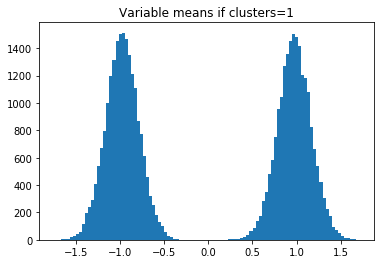

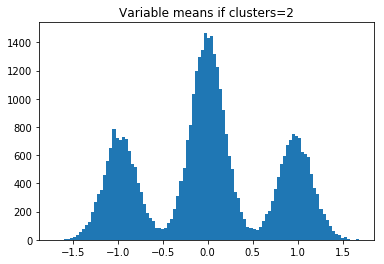

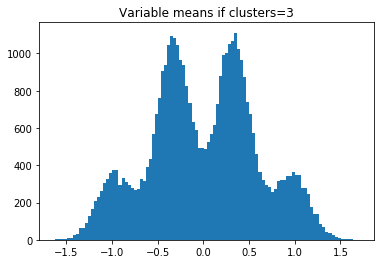

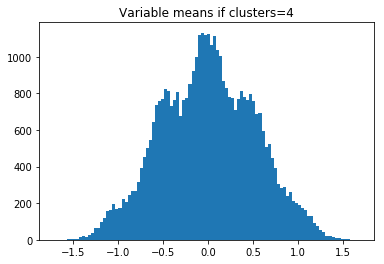

In [27]:
for clusters in range(4):
    centers = np.array([])
    for k in range(512):
        X, y = make_classification(n_samples=768, n_features=useful[k], 
                    n_informative=useful[k], n_redundant=0, n_repeated=0, 
                    n_classes=2, n_clusters_per_class=clusters+1, weights=None, 
                    flip_y=0.05, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, 
                    shuffle=True, random_state=None)
        centers = np.append(centers,np.mean(X[ np.argwhere(y==0).flatten() ,:],axis=0))
        centers = np.append(centers,np.mean(X[ np.argwhere(y==1).flatten() ,:],axis=0))
    plt.hist(centers,bins=100)
    plt.title('Variable means if clusters='+str(clusters+1))
    plt.show()


## Now let's plot the real data
First we will use QDA to create pseudo labels for the public test data. Then we will plot a histogram of the variable means (data centers' coordinates) of target=0 and target=1 using all training and pseudo labeled public test data combined (768 rows per sub dataset). The plot below shows that Kaggle used `n_clusters_per_class=3`.

In [28]:
centers = np.array([])
for k in range(512):
    
    # REAL DATA
    df_train2 = df_train[df_train['wheezy-copper-turtle-magic']==k]
    df_test2 = df_test[df_test['wheezy-copper-turtle-magic']==k]
    sel = VarianceThreshold(1.5).fit(df_train2.iloc[:,1:-1])
    df_train3 = sel.transform(df_train2.iloc[:,1:-1])
    df_test3 = sel.transform(df_test2.iloc[:,1:])
    obs = df_train3.shape[0]
    X = np.concatenate((df_train3,df_test3),axis=0)
    y = np.concatenate((df_train2['target'].values,np.zeros(len(df_test2))))
    
    # TRAIN AND TEST DATA
    train = X[:obs,:]
    train_y = y[:obs]
    test = X[obs:,:]
    test_y = y[obs:]
    comb = X
                
    # FIRST MODEL : QDA
    clf = QuadraticDiscriminantAnalysis(priors = [0.5,0.5])
    clf.fit(train,train_y)
    test_pred = clf.predict_proba(test)[:,1]
    
    # SECOND MODEL : PSEUDO LABEL + QDA
    test_pred = test_pred > np.random.uniform(0,1,len(test_pred))
    clf = QuadraticDiscriminantAnalysis(priors = [0.5, 0.5])
    clf.fit(comb, np.concatenate((train_y,test_pred)) )
    test_pred = clf.predict_proba(test)[:,1]
    
    # PSEUDO LABEL TEST DATA
    test_pred = test_pred > np.random.uniform(0,1,len(test_pred))
    y[obs:] = test_pred
    
    # COLLECT CENTER COORDINATES
    centers = np.append(centers,np.mean(X[ np.argwhere(y==0).flatten() ,:],axis=0))
    centers = np.append(centers,np.mean(X[ np.argwhere(y==1).flatten() ,:],axis=0))
    
# PLOT CENTER COORDINATES
plt.hist(centers,bins=100)
plt.title('Real Data Variable Means (match clusters=3)')
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 256)) while a minimum of 1 is required.

# Appendix 2 - Advanced Techniques
Since the code above already classifies Sklearn's `make_classification` on average prefectly, there is no need to improve it. However, below are some ideas that could be used if improvement was possible and/or neccessary.

1. After building model 4's classifier, you could use it to classify the training data. Then all training data with `abs(oof - true)>0.9` are erroneous training data with their labels flippped. Next correct those training labels and run the entire kernel a second time.

2. Since each cluster is centered at a hypercube corner, you can modify Sklearn's Quadratic Discriminant Analysis code by adding `meang[ np.argwhere(meang>=0) ] = 1.0` and `meang[ np.argwhere(meang<0) ] = -1.0`. This moves the centers of all clusters to hypercube corners.

3. Computer accuracy cannot distinguish between predictions that are close to 1. Using an example with 6 digit accuracy, the numbers 1.000001 and 1.000002 are the same because both become 1.00000. To help improve AUC, you can add the following code to this kernel. `temp = np.log(pds[:,0]+pds[:,1]+pds[:,2])`; `temp[ np.isinf(temp) ] = -1e6`; `test_pred -= temp`. This improves AUC by differentiating between predictions close to 1. Note that this isn't a problem for predictions close to 0 because the numbers 0.0000001 and 0.0000002 are 1.0e-7 and 2.0e-7 and the computer can already differentiate them.

4. After making predictions for `test.csv`, you can use them as pseudo labels and run the entire kernel a second time. Then use those labels and run the kernel a third time. Each iteration can give a slight boost.

5. You can run this kernel multiple times and take an average. Or use k-folds. This removes this code's variance (randomness) and achieves close to prefection everytime but it also removes the possibility of scoring LB 0.00050 more or less than perfection.

6. We can also remove this code's variance (randomness) by modifying Sklearn's code for Quadratic Discriminant Analysis and Gaussian Mixture. Each of these models can only accept training labels that are either 0 or 1. By adding a few lines of code, we can allow these models to accept continuous probabilities and use them as weights. This would allow us to remove the randomization line `test_pred = test_pred > np.random.uniform(0,1,len(test_pred))`. Instead we can leave pseudo labels as probabilities between 0 and 1 and still call `QuadraticDiscriminantAnalysis.fit(test_data,test_pred)`.

Using combinations of these additional advanced techniques, this kernel was able to score LB 0.97489 on this competition's public leaderboard. But validation showed that these techniques didn't make the basic perfect classifier any more perfect. Therefore for final submission, the basic classifier was used.

# Appendix 3 - Final Submission Strategy
By applying our model to synthetic data, we can learn how it performs on a simulated public and private leaderboard. We observe that this kernel achieves perfection on average (if Kaggle used `make_classification` with the parameters we suspect). Sklearn's code for `make_classification` includes

        # Randomly replace labels
        if flip_y >= 0.0:
            flip_mask = generator.rand(n_samples) < flip_y
            y[flip_mask] = generator.randint(n_classes, size=flip_mask.sum())
            
Before variable `y` gets rewritten, you can store it by adding `y_orig = y.copy()`. Next update the shuffle line to `X, y, y_orig = util_shuffle(X, y, y_orig, random_state=generator)`. Then change the last line of `make_classification` to `return X, y, y_orig`. By doing this, we can compute the AUC of a perfect classifier with `prefect = roc_auc_score(y, y_orig)`.
 
Now we can make hundreds of synthetic datasets that are the similar to this competition's data and apply this kernel to see how well it does compared with a perfect classifier. For each synthetic dataset, we will run this kernel 10 times. This will show us patterns and help us decide how to choose our two final submissions. 
 
We observe that sometimes this kenel does better than perfect and sometimes it does worse than perfect. It's interesting to note that there is no correlation between its performance on public LB versus private LB. In the example plots below, perfect classification is represented by the black dotted line.

If we take the average of this kernel's performance over many sythnetic datasets, it achieves perfect classification. Therefore there is no reason to improve this kernel. We can never expect to perform better than perfect classification on average. The only change we could consider is altering this kernel's standard deviation from perfection. We could either try to achieve perfection every kernel run, or (leave it as is and) randomly try to exceed perfection by a desired amount on some kernel runs.
 
## Synthetic Dataset 1
![image](http://playagricola.com/Kaggle/ex161919.png)
## Synthetic Dataset 2
![image](http://playagricola.com/Kaggle/ex261919.png)
## Synthetic Dataset 3
![image](http://playagricola.com/Kaggle/ex361919.png)
## Synthetic Dataset 4
![image](http://playagricola.com/Kaggle/ex461919.png)
## Synthetic Dataset 5
![image](http://playagricola.com/Kaggle/ex561919.png)
## Many Synthetic Datasets Together
![image](http://playagricola.com/Kaggle/scatter61719.png)